# Supplementary Material

> **"Background-dependent selection of genetic variation in heterogeneous populations"**

> Ignacio Vázquez-García, Francisco Salinas, Jing Li, Andrej Fischer, Benjamin Barré, Johan Hallin, Anders Bergström, Elisa Alonso-Pérez, Jonas Warringer, Ville Mustonen, Gianni Liti

## Figure 1 (+ Supp. Figs.)

This IPython notebook is provided for reproduction of Figure 1 of the paper. It can be viewed by copying its URL to nbviewer and it can be run by opening it in binder.

In [1]:
# load external dependencies
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.patheffects as PathEffects
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

import numpy as np
import pandas as pd # (*) Pandas for data manipulation

import json,matplotlib
s = json.load( open("matplotlibrc.json") )
matplotlib.rcParams.update(s)

# load internal dependencies
import colors,plot,utils,config
from utils import sgd_length

# absolute file path for root directory of git repo
dir_repo = utils.get_git_path()
dir_data = dir_repo+"/data/"
dir_paper = dir_repo+"/manuscript/main/"
dir_supp = dir_repo+"/manuscript/supp/"

%load_ext autoreload
%autoreload 2

import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

## Data import

In [2]:
# load data
freq_df = utils.load_data(dir_data+'seq/background/seq_background_freq.pickle')

freq_df.head()

chr_arabic                            1                                       \
chr_roman                              I                                       
site                              2718     2731     2734     4532     5035     
pos                             2718     2731     2734     4532     5035       
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.926    0.926    0.926    0.948    0.944   
                           2       0.920    0.920    0.920    0.932    0.924   
                           4       0.931    0.931    0.931    0.948    0.951   
                           8       0.929    0.930    0.930    0.944    0.949   
                           16      0.956    0.957    0.957    0.969    0.960   

chr_arabic                                                                    \
chr_roman                                                                      
site                              5218     5237     6556     6652     6673     
pos                             5218     5237     6556     6652     6673       
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.942    0.942    0.921    0.921    0.921   
                           2       0.922    0.922    0.957    0.960    0.960   
                           4       0.948    0.948    0.954    0.954    0.955   
                           8       0.951    0.951    0.954    0.953    0.953   
                           16      0.956    0.956    0.965    0.967    0.968   

chr_arabic                        ...          16                             \
chr_roman                         ...         XVI                              
site                              ...      924009   924127   924130   924152   
pos                               ...    12047269 12047387 12047390 12047412   
selection sample           time   ...                                          
HU        WAxNA_F12_1_HU_1 0      ...       0.393    0.394    0.394    0.394   
                           2      ...       0.432    0.430    0.430    0.430   
                           4      ...       0.391    0.391    0.391    0.391   
                           8      ...       0.404    0.402    0.402    0.402   
                           16     ...       0.358    0.355    0.355    0.355   

chr_arabic                                                                    \
chr_roman                                                                      
site                              924943   925012   925027   925033   926851   
pos                             12048203 12048272 12048287 12048293 12050111   
selection sample           time                                                
HU        WAxNA_F12_1_HU_1 0       0.412    0.414    0.415    0.415    0.428   
                           2       0.440    0.440    0.441    0.441    0.437   
                           4       0.394    0.394    0.394    0.394    0.409   
                           8       0.398    0.397    0.397    0.397    0.407   
                           16      0.360    0.361    0.361    0.361    0.376   

chr_arabic                                
chr_roman                                 
site                              927911  
pos                             12051171  
selection sample           time           
HU        WAxNA_F12_1_HU_1 0       0.428  
                           2       0.454  
                           4       0.414  
                           8       0.415  
                           16      0.382  

[5 rows x 52466 columns]

In [3]:
# load data
seq_qtl_df = utils.load_data(dir_data+'seq/background/seq_background_qtl_llh.pickle')

seq_qtl_df.head()

resolution                                       2                    \
selection                                        RM                    
sample                             WAxNA_F12_1_RM_1 WAxNA_F12_1_RM_2   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868          4.74411         0.146892   
                     12985 4842915          4.73818         0.147830   
                     12997 4842927          4.73817         0.147831   
                     13185 4843115          5.15313         0.283097   
                     13408 4843338          5.10120         0.288338   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_1_RM_3 WAxNA_F12_1_RM_4   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868         0.077782         0.969071   
                     12985 4842915         0.077782         0.969076   
                     12997 4842927         0.080084         0.975848   
                     13185 4843115         0.067989         1.243700   
                     13408 4843338         0.074025         1.258580   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_2_RM_1 WAxNA_F12_2_RM_2   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868         0.020155         0.786893   
                     12985 4842915         0.020154         0.786894   
                     12997 4842927         0.020154         0.786893   
                     13185 4843115         0.012097         0.711532   
                     13408 4843338         0.012085         0.711693   

resolution                                                            \
selection                                                              
sample                             WAxNA_F12_2_RM_3 WAxNA_F12_2_RM_4   
chr_arabic chr_roman site  pos                                         
8          VIII      12938 4842868          5.78286         0.416840   
                     12985 4842915          5.78284         0.416847   
                     12997 4842927          5.78283         0.416840   
                     13185 4843115          4.34863         0.764097   
                     13408 4843338          4.30180         0.785666   

resolution                                                          \
selection                                                            
sample                             WAxNA_F2_1_RM_1 WAxNA_F2_1_RM_2   
chr_arabic chr_roman site  pos                                       
8          VIII      12938 4842868         1.35615         3.14470   
                     12985 4842915         1.35616         3.14470   
                     12997 4842927         1.35616         3.14470   
                     13185 4843115         1.73894         5.42792   
                     13408 4843338         1.74750         5.43454   

resolution                               ...                      50  \
selection                                ...                      RM   
sample                                   ...        WAxNA_F12_2_RM_2   
chr_arabic chr_roman site  pos           ...                           
8          VIII      12938 4842868       ...                0.957498   
                     12985 4842915       ...                0.912791   
                     12997 4842927       ...                0.912798   
                     13185 4843115       ...                0.999568   
                     13408 4843338       ...                0.943480   

resolution                                                            \
selection                                           

In [4]:
# load data
seq_scores_df = utils.load_data(dir_data+'seq/background/seq_background_qtl_scores.pickle')

seq_scores_df.head()

resolution                                  2   5   10  30  50
selection                                   RM  RM  RM  RM  RM
chr_arabic chr_roman site   pos                               
8          VIII      454120 5284050  41.690200 NaN NaN NaN NaN
                     454160 5284090  81.800000 NaN NaN NaN NaN
                     454436 5284366  19.191600 NaN NaN NaN NaN
                     454745 5284675   0.087844 NaN NaN NaN NaN
                     455368 5285298  32.664115 NaN NaN NaN NaN

In [5]:
# load data
seq_mut_df = utils.load_data(dir_data+'seq/de-novo/seq_de_novo_snps_indels.pickle')

seq_mut_df = seq_mut_df.rename(columns={'chrom':'chr_arabic', 'pos':'site'})
seq_mut_df['chr_roman'] = seq_mut_df['chr_arabic'].apply(utils.int_to_roman)
seq_mut_df = utils.chr_to_gw(seq_mut_df)

seq_mut_df = seq_mut_df[seq_mut_df.mutation_type=='driver']

# remap genotypes
seq_mut_df['genotype'] = seq_mut_df['genotype'].map({'0/0': 0, '0/1': 1, '1/0': 1, '1/1': 2})

seq_mut_df['type'] = 'de novo'

seq_mut_df = pd.pivot_table(seq_mut_df, 
                           index=['selection','population'], 
                           columns=['chr_arabic','chr_roman','pos','gene'])['frequency']

seq_mut_df.head()

chr_arabic                        7                           10          \
chr_roman                        VII                           X           
pos                          4594951   4595191   4595192 6225315 6225325   
gene                            RNR4      RNR4      RNR4    RNR2    RNR2   
selection population                                                       
HU        NA_HU_1           0.078095  0.034108       NaN     NaN     NaN   
          NA_HU_2           0.098413  0.040323       NaN     NaN     NaN   
          WAxNA_F12_1_HU_1       NaN  0.126111  0.196517     NaN     NaN   
          WAxNA_F12_1_HU_2       NaN  0.952381       NaN     NaN     NaN   
          WAxNA_F12_1_HU_3       NaN       NaN       NaN     NaN     NaN   

chr_arabic                                                                   \
chr_roman                                                                     
pos                         6225369 6225481 6397791 6397792 6397989 6397990   
gene                           RNR2    RNR2    TOR1    TOR1    TOR1    TOR1   
selection population                                                          
HU        NA_HU_1               NaN     NaN     NaN     NaN     NaN     NaN   
          NA_HU_2               NaN     NaN     NaN     NaN     NaN     NaN   
          WAxNA_F12_1_HU_1      NaN     NaN     NaN     NaN     NaN     NaN   
          WAxNA_F12_1_HU_2      NaN     NaN     NaN     NaN     NaN     NaN   
          WAxNA_F12_1_HU_3  0.28502     NaN     NaN     NaN     NaN     NaN   

chr_arabic                              14                          
chr_roman                              XIV                          
pos                        6398011 9619557 9619666 9619831 9619860  
gene                          TOR1    FPR1    FPR1    FPR1    FPR1  
selection population                                                
HU        NA_HU_1              NaN     NaN     NaN     NaN     NaN  
          NA_HU_2              NaN     NaN     NaN     NaN     NaN  
          WAxNA_F12_1_HU_1     NaN     NaN     NaN     NaN     NaN  
          WAxNA_F12_1_HU_2     NaN     NaN     NaN     NaN     NaN  
          WAxNA_F12_1_HU_3     NaN     NaN     NaN     NaN     NaN

## Figure 1 - Study overview and genome-wide allele frequency changes

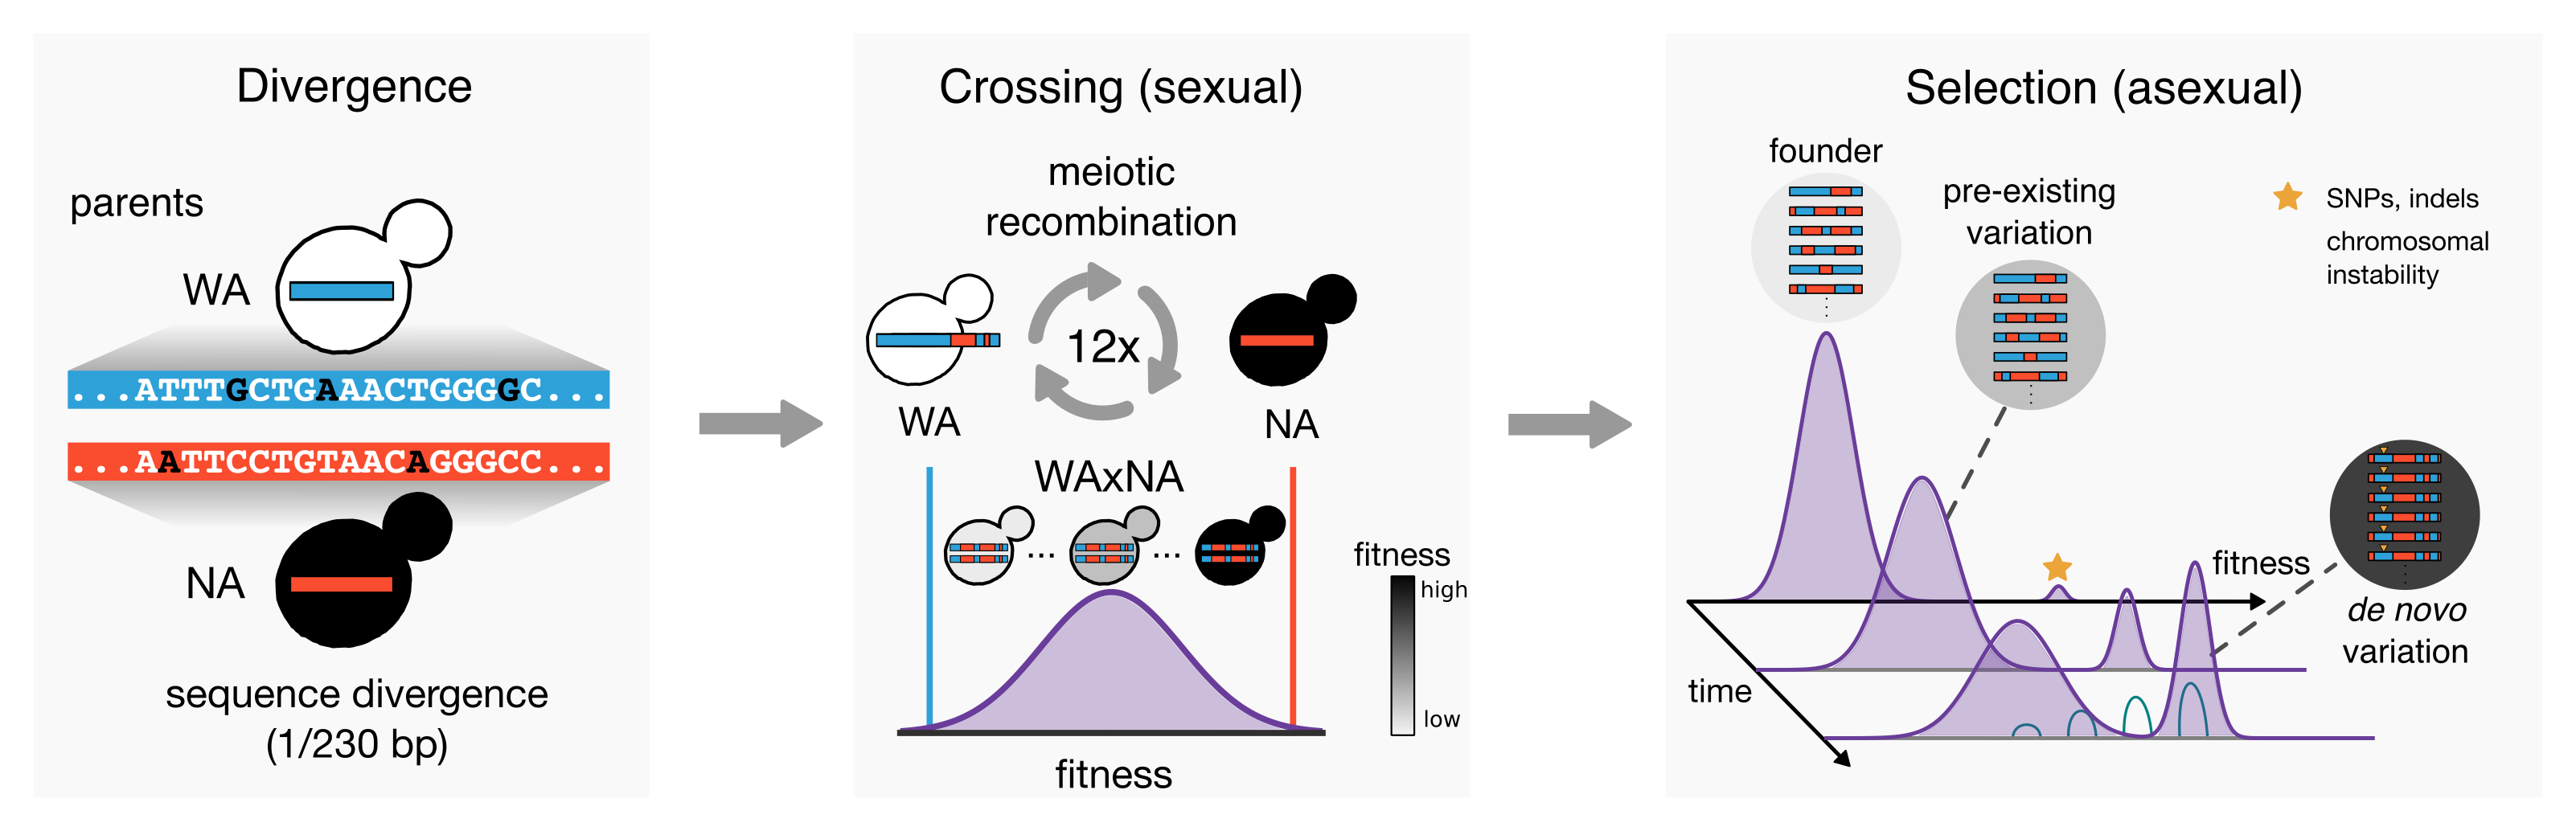

In [6]:
from IPython.display import Image
Image(filename=dir_paper+'figures/figure1/figure1A_schematic_submission.png')

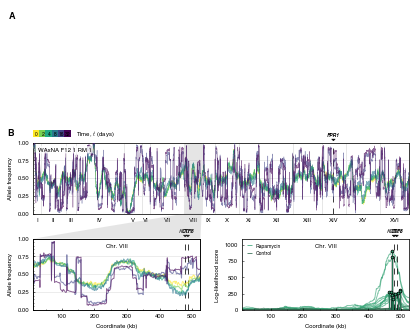

In [7]:
fig = plt.figure(figsize=(6, 5), dpi=300)

grid = gridspec.GridSpec(3, 1, height_ratios=[1.5,1,1], hspace=0.3)

gs = {}
gs['schematic'] = gridspec.GridSpecFromSubplotSpec(1, 3, width_ratios=[1,1,2], subplot_spec=grid[0])
gs['RM'] = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=grid[1])
gs['RM_zoom'] = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=grid[2], wspace=0.25)

### top panel ###
ax0 = plt.subplot(gs['schematic'][0])

ax0.text(-0.225, 1.0, 'A', transform=ax0.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

ax0.axis('off')
ax0.patch.set_visible(False)

### genome-wide allele frequency changes (top panel) ###
e = 'RM'
p = 'WAxNA_F12_1_RM_1'
    
ax1 = plt.subplot(gs[e][0])
ax1.text(-0.0525, 1.2, 'B', transform=ax1.transAxes,
         fontsize=9, fontweight='bold', va='top', ha='right')

pdf = freq_df.ix[(e,p)].T

colors = [config.time['color'][k] for k in pdf.columns.get_level_values('time')]
pdf.reset_index().plot(ax=ax1, kind='line',
                       x='pos', y=[0,2,4,8,16,32],
                       color=colors, alpha=0.6, lw=0.45, 
                       legend=False, zorder=3)
    
ax1.set_xlabel('')
ax1.set_ylabel('Allele frequency')

ax1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
ax1.yaxis.set_minor_locator(ticker.MaxNLocator(nbins=20))
ax1.yaxis.set_ticks_position('left')
    
# grid
xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
xstart = sgd_length.chr_start
ax1.set_xticks(xlabels)
ax1.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
xgrid=[xst+1. for xst in list(set(xstart))]
[ax1.axvline(g, lw=1, ls="-", color="0.9") for g in xgrid] # vertical lines
ax1.yaxis.grid(lw=0.75, ls="-", color="0.9") # horizontal lines
    
#     # shades
#     for start, end in zip(sgd_length.chr_start, sgd_length.chr_end):
#         for chrom, g in sgd_length.groupby('chr_arabic'):
#             ax1.axvspan(g.chr_start.squeeze(), g.chr_end.squeeze(),
#                         color=('0.9' if chrom % 2 == 0 else 'w'), lw=0, zorder=0) 
    
ax1.annotate(p.replace('_',' '),
             xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6,
             color='k', ha='left', va='center',
             xytext=(-5,0), textcoords='offset points', 
             bbox=(dict(facecolor='white', edgecolor='none', 
                        alpha=0.75, boxstyle='round,pad=.2')))
    
ax1.tick_params(axis='x', which='major', size=0, labelsize=6)
ax1.tick_params(axis='y', which='major', size=2, labelsize=6)
ax1.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
# show de novo mutations
sdn = seq_mut_df.ix[e,p].dropna(how='all')
    
labels = sdn.index.get_level_values('gene')
loc = zip(sdn.index.get_level_values('pos'), [1.025]*len(sdn))
    
for gene, (x, y) in zip(labels, loc):
    ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=2)
    ann = ax1.annotate(gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
                       xytext=(0, 4), textcoords='offset points',
                       arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                       fontsize=5, style='italic', weight='bold',
                       annotation_clip=False, va='bottom', ha='center')

# legend
cax = inset_axes(ax1, width='10%', height='10%', loc=3,
                 bbox_to_anchor=(0, 1.075, 1, 1),
                 bbox_transform=ax1.transAxes,
                 borderpad=0)
mappable = plot.colorbar_index(ncolors=6, cmap=plt.cm.viridis_r) 
cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar.ax.get_xaxis().set_ticks([])
for j, lab in enumerate([0, 2, 4, 8, 16, 32]):
    cbar.ax.text((j + .5)/ 6.0, .5, lab, ha='center', va='center', fontsize=5)
cbar.ax.yaxis.set_label_position("right")
cbar.ax.set_ylabel('Time, $t$ (days)', fontsize=5, rotation=0, ha='left', va='center')            
cbar.outline.set_visible(False)
        
### zoomed inset (bottom left panel) ###
ax2 = plt.subplot(gs['RM_zoom'][0])
ax2_zoom = ax2.twiny()

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
xmin = sgd_length[sgd_length.chr_arabic==8].chr_start.squeeze()
xmax = sgd_length[sgd_length.chr_arabic==8].chr_end.squeeze()

ax2_zoom.set_xlim(xmin, xmax)
ax2_zoom.set_xticks([])
ax2_zoom.set_xticklabels([])

plot.zoom_effect(ax1, ax2_zoom, xmin, xmax, edgecolor='none', facecolor='gray')#, edgewidth=5)

freq = freq_df.loc[('RM','WAxNA_F12_1_RM_1'),8].T

colors = [config.time['color'][k] for k in freq.columns.get_level_values('time')]
freq.reset_index().plot(ax=ax2, kind='line',
                        x='site', y=[0,2,4,8,16,32],
                        color=colors, alpha=0.6, lw=1,
                        legend=False)

ax2.set_xlabel('Coordinate (kb)')
ax2.set_ylabel('Allele frequency')

ax2.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax2.xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
ax2.yaxis.set_minor_locator(ticker.MaxNLocator(nbins=20))
ax2.yaxis.set_ticks_position('left')

ax2.yaxis.grid(lw=0.75, ls="-", color="0.9") # horizontal lines

xticks = ax2.get_xticks()/1E3
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks.astype(int))

ax2.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax2.transAxes, fontsize=6,
             color='k', ha='center', va='center')

### log-likelihood scores (bottom right panel) ###
ax3 = plt.subplot(gs['RM_zoom'][1], sharex=ax2)

# slice chr. VIII at 30 kb resolution
llh = seq_qtl_df.loc[8,30]
colors = [config.selection['color'][e] for e in llh.columns.get_level_values('selection')]
llh.reset_index().plot(ax=ax3, kind='line',
                       x='site', y=['RM','YPD'],
                       color=colors, alpha=0.6, lw=1,
                       legend=False, zorder=0)

scores = seq_scores_df[30,'RM'].dropna()
markerline, stemlines, baseline = ax3.stem(scores.index.get_level_values('site'), scores.values)
plt.setp(markerline, 'color', config.selection['color']['RM'],
         markersize = 2.75, markeredgewidth=.75, markeredgecolor='k', zorder=3)
plt.setp(stemlines, linewidth=.75, color=config.selection['color']['RM'],
         path_effects=[PathEffects.withStroke(linewidth=1.25, foreground="k")], zorder=2)  
plt.setp(baseline, 'color', 'none', zorder=1)

ax3.set_xlabel('Coordinate (kb)')
ax3.set_ylabel('Log-likelihood score')

# axes limits
ax3.set_ylim(0, 1.1E3)
ax3.xaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
ax3.xaxis.set_minor_locator(ticker.MaxNLocator(nbins=12))
ax3.xaxis.set_ticks_position('bottom')
ax3.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
ax3.yaxis.set_ticks_position('left')

# annotation in chromosome coordinates
annotation = {
    'CTF8': {
        'chr': 8,
        'start': 486230,
        'end': 486631
    },
    'KOG1': {
        'chr': 8,
        'start': 475999,
        'end': 480672       
    }
}

RM_artist = lines.Line2D((0,1),(0,0), color=config.selection['color']['RM'], linewidth=.75)
YPD_artist = lines.Line2D((0,1),(0,0), color=config.selection['color']['YPD'], linewidth=.75)

leg3 = ax3.legend([RM_artist,YPD_artist],
                  ['Rapamycin','Control'], ncol=1,
                  frameon=False, loc='upper left',
                  borderaxespad=0.5, handlelength=1, 
                  prop={'size': 5})
plt.setp(leg3.get_title(), fontsize=6)

ax3.annotate('Chr. VIII',
             xy=(0.5, 0.9), xycoords=ax3.transAxes, fontsize=6,
             color='k', ha='center', va='center')

for ax in [ax2,ax3]:
    
    ax.tick_params(axis='both', which='major', size=2, labelsize=6)
    ax.tick_params(axis='both', which='minor', size=1, labelsize=4)
    
    for gene in annotation:
        x = annotation[gene]['start'] + (annotation[gene]['end'] - annotation[gene]['start'])/2
        y = 1.025
        ax.axvline(x=x, c='k', ls="--", lw=.75, zorder=1)
        ann = ax.annotate(gene, xy=(x, y), xycoords=('data', 'axes fraction'), 
                          xytext=(0, 4), textcoords='offset points',
                          arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                          fontsize=5, style='italic', weight=('bold' if gene=='CTF8' else 'normal'),
                          annotation_clip=False, va='bottom', ha='center')

for ax in fig.get_axes():
    ax.xaxis.label.set_size(6)
    ax.yaxis.label.set_size(6)
    
    for sp in ax.spines.values():
        sp.set(color='k', linewidth=0.75, linestyle='-')
    
fig.savefig(dir_paper+'figures/figure1/figure1.png', dpi=300, bbox_inches='tight')
fig.savefig(dir_paper+'figures/figure1/figure1.svg', dpi=300, bbox_inches='tight')
plt.show()

**Fig. 1:** Study overview and genome-wide allele frequency changes. (**A**) Two diverged parental lines of *S. cerevisiae* were crossed for twelve rounds, generating a large ancestral population of unique haplotypes. These diploid cells were asexually evolved for 32 days in drug (and control) environments and the resulting adaptation was studied by whole-population and isolate sequencing and phenotyping. Populations evolved resistant macroscopic clones driven by beneficial de novo mutations and individuals whose parental allele configurations, i.e. genetic backgrounds, provided a resistance phenotype. (**B**) Genome-wide allele frequency  of pre-existing parental variants as observed for a representative population in rapamycin (WAxNA F12 1 RM 1). Bottom left: Zoomed inset of the shaded region shows allele frequency changes in chromosome VIII during selection in rapamycin. Early time points 2, 4 and 8 show localized allele frequency changes at 460-490 kb due to a beneficial allele sweeping with hitchhiking passengers. Late time points 16 and 32 show abrupt jumps between successive loci that reflect the parental haplotype of the emerging clone(s). In case of a fully clonal population, the allele frequencies would be at 0, 0.5 and 1.0 corresponding to the background genotype NA/NA, WA/NA, and WA/WA of a diploid clone that reached fixation. Bottom right: We tested a model where each allele is proposed to be a driver under selection thus changing in frequency and causing movement in nearby linked passenger alleles. Top log-likelihood scores are shown for all populations in this region of interest (see Methods). We validated the *CTF8* NA allele to be a strong QTL for rapamycin resistance (Fig. S10).

## Figure S1 - Study overview and genome-wide allele frequency changes

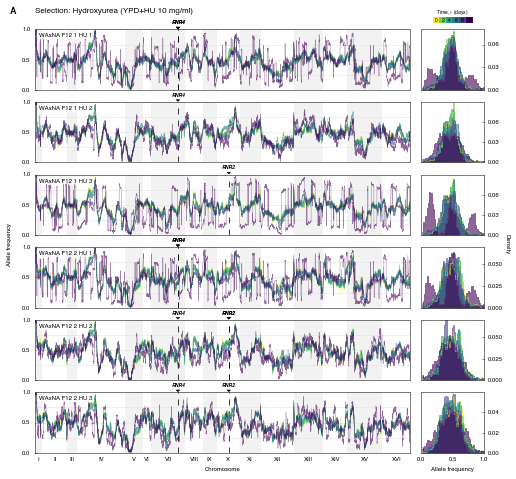

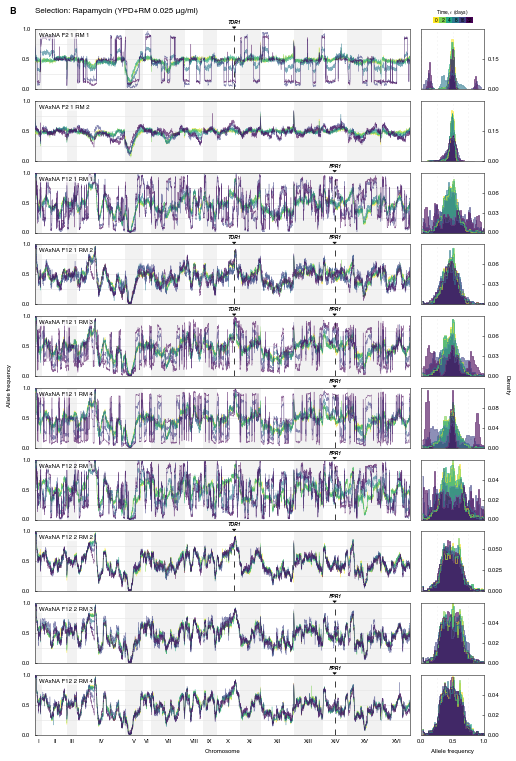

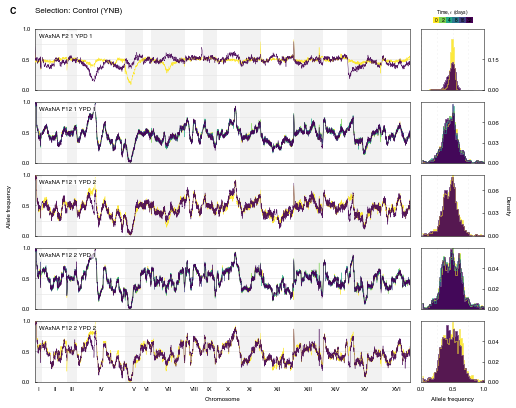

In [8]:
panels = {
    'HU': {
        'WAxNA_F12_1_HU_1':0, 
        'WAxNA_F12_1_HU_2':1, 
        'WAxNA_F12_1_HU_3':2, 
        'WAxNA_F12_2_HU_1':3, 
        'WAxNA_F12_2_HU_2':4,
        'WAxNA_F12_2_HU_3':5
        },
    'RM': {
        'WAxNA_F2_1_RM_1':0,
        'WAxNA_F2_1_RM_2':1,
        'WAxNA_F12_1_RM_1':2, 
        'WAxNA_F12_1_RM_2':3, 
        'WAxNA_F12_1_RM_3':4, 
        'WAxNA_F12_1_RM_4':5,
        'WAxNA_F12_2_RM_1':6, 
        'WAxNA_F12_2_RM_2':7, 
        'WAxNA_F12_2_RM_3':8, 
        'WAxNA_F12_2_RM_4':9   
    },
    'YPD': {
        'WAxNA_F2_1_YPD_1':0,
        'WAxNA_F12_1_YPD_1':1, 
        'WAxNA_F12_1_YPD_2':2, 
        'WAxNA_F12_2_YPD_1':3, 
        'WAxNA_F12_2_YPD_2':4
    }
}

freq_df = freq_df.ix[['HU','RM','YPD']]

shape = pd.DataFrame({k: 
x.shape for k,x in freq_df.unstack('time').groupby(level=['selection'])
})

ygrid = shape.loc[0,['HU','RM','YPD']].values

gs = {}

for ii, (e, sdf) in enumerate(freq_df.groupby(level='selection')):
    
    nrows = len(sdf.index.get_level_values('sample').unique())
    ncols = 2
            
    height, width = np.array([nrows, ncols*4], dtype=float)
    
    fig = plt.figure(figsize=(width, height), dpi=300)
    
    fig.subplots_adjust(left=0.07,bottom=0.01,right=0.85,top=0.99)
    
    gs[e] = gridspec.GridSpec(nrows, ncols, width_ratios=[6, 1], hspace=0.2, wspace=0.05)

    for (jj, (p, pdf)) in enumerate(sdf.groupby(level='sample')):
        
        if jj==0:
            # retrieve axes
            ax1 = plt.subplot(gs[e][panels[e][p],0])
            ax2 = plt.subplot(gs[e][panels[e][p],1])
        else:
            ax1 = plt.subplot(gs[e][panels[e][p],0], sharex=ax1)
            ax2 = plt.subplot(gs[e][panels[e][p],1], sharex=ax2)
        
        pdf = freq_df.ix[(e,p)].T

        colors = [config.time['color'][k] for k in pdf.columns.get_level_values('time')]
        pdf.reset_index().plot(ax=ax1, kind='line',
                               x='pos', y=pdf.columns,
                               color=colors, lw=0.4, alpha=(0.6 if e in ['HU','RM'] else 0.9), 
                               legend=False, zorder=3)
        
        for time in pdf:    
            x, y = plot.histogram_binned_data(ax2, pdf[time], bins=50)
            ax2.plot(x, y, color=config.time['color'][time], lw=0.5)
            ax2.fill_between(x, 0, y, label=time, alpha=(0.6 if e in ['HU','RM'] else 0.9), 
                             facecolor=config.time['color'][time])            
        
        ax1.set_ylim((0, 1))
        ax1.yaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
        ax1.yaxis.set_minor_locator(ticker.MaxNLocator(nbins=4))
        ax1.yaxis.set_ticks_position('left')
        
        ax2.set_xlim((0, 1))
        ax2.xaxis.set_major_locator(ticker.MaxNLocator(nbins=2))
        ax2.xaxis.set_minor_locator(ticker.MaxNLocator(nbins=4))
        ax2.yaxis.set_major_locator(ticker.MaxNLocator(nbins=3, prune='upper'))
        ax2.yaxis.set_ticks_position('right')
        
        if (e,p) in [('HU','WAxNA_F12_2_HU_3'),('RM','WAxNA_F12_2_RM_4'),('YPD','WAxNA_F12_2_YPD_2')]:
            ax1.set_xlabel('Chromosome')
            ax2.set_xlabel('Allele frequency')
        if (e,p) in [('HU','WAxNA_F12_1_HU_3'),('RM','WAxNA_F12_1_RM_3'),('YPD','WAxNA_F12_1_YPD_2')]:
            xy = {'HU':(-.06, -.15),'RM':(-.06, -.15),'YPD':(-.06, .5)}
            ax1.annotate('Allele frequency', 
                         xy=xy[e], xycoords=ax1.transAxes,
                         color='k', fontsize=6, ha='right', va='center', rotation=90,
                         xytext=(0, 0), textcoords='offset points')
            xy = {'HU':(1.4, -.15),'RM':(1.4, -.15),'YPD':(1.4, .5)}
            ax2.annotate('Density', 
                         xy=xy[e], xycoords=ax2.transAxes,
                         color='k', fontsize=6, ha='right', va='center', rotation=270,
                         xytext=(0, 0), textcoords='offset points')
            
        # set panel labels
        if ax1.is_first_row():
            ax1.text(-0.05, 1.3, chr(ii + ord('A')), transform=ax1.transAxes,
                     fontsize=9, fontweight='bold', va='center', ha='right')
            ax1.text(0, 1.3, 'Selection: %s' % config.selection['long_label'][e], 
                     transform=ax1.transAxes, fontsize=8, va='center', ha='left')

        # grid
        xlabels = sgd_length.chr_start + (sgd_length.chr_end - sgd_length.chr_start)/2.
        xstart = sgd_length.chr_start
        xgrid=[xst+1. for xst in list(set(xstart))]
        ax1.yaxis.grid(lw=0.6, ls='-', color='0.9', which='minor')
        ax2.xaxis.grid(lw=0.6, ls=':', color='0.9', which='minor')
        
        # labels
        if ax1.is_last_row():
            ax1.set_xticks(xlabels)
            ax1.set_xticklabels(sgd_length.chr_arabic.apply(utils.int_to_roman))
        
        # shades
        for start, end in zip(sgd_length.chr_start, sgd_length.chr_end):
            for chrom, g in sgd_length.groupby('chr_arabic'):
                ax1.axvspan(g.chr_start.squeeze(), g.chr_end.squeeze(),
                            color=('0.95' if chrom % 2 == 1 else 'w'), lw=0, zorder=0) 
    
        ax1.annotate(p.replace('_',' '),
                     xy=(0.025, 0.9), xycoords=ax1.transAxes, fontsize=6,
                     color='k', ha='left', va='center',
                     xytext=(-5,0), textcoords='offset points', 
                     bbox=(dict(facecolor='white', edgecolor='none', 
                                alpha=0.75, boxstyle='round,pad=.2')))
        
        # legend
        if ax1.is_first_row():

            cax = inset_axes(ax2, width='80%', height='10%', loc=8,
                             bbox_to_anchor=(0.1, 1.1, 0.8, 1),
                             bbox_transform=ax2.transAxes,
                             borderpad=0)
            mappable = plot.colorbar_index(ncolors=6, cmap=plt.cm.viridis_r) 
            cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
            cbar.ax.get_xaxis().set_ticks([])
            for j, lab in enumerate([0, 2, 4, 8, 16, 32]):
                cbar.ax.text((j + .5)/ 6.0, .5, lab, ha='center', va='center', fontsize=5)
            cbar.ax.set_title('Time, $t$ (days)', fontsize=5, ha='center', va='center')            
            cbar.outline.set_visible(False)
                    
        # show de novo mutations
        if (e,p) in seq_mut_df.index:
        
            sdn = seq_mut_df.ix[e,p].dropna(how='all')
                
            labels = sdn.index.get_level_values('gene')
            loc = zip(sdn.index.get_level_values('pos'), [1.01]*len(sdn))
    
            for gene, (x,y) in zip(labels, loc):
                ax1.axvline(x=x, c='k', ls="--", lw=.75, zorder=1)
                ann = ax1.annotate(gene, xy=(x,y), xycoords=('data', 'axes fraction'), 
                                   xytext=(0, 4), textcoords='offset points',
                                   arrowprops=dict(arrowstyle='wedge,tail_width=0.7', color='black'),
                                   fontsize=5, style='italic', weight='bold',
                                   va='bottom', ha='center')

    for ax in fig.get_axes():
        ax.xaxis.label.set_size(6)
        ax.yaxis.label.set_size(6)
        ax.tick_params(axis='both', which='major', size=2, labelsize=6)
        ax.tick_params(axis='both', which='minor', size=0, labelsize=0)
    
        for sp in ax.spines.values():
            sp.set(color='k', linewidth=0.5, linestyle='-')
    
        # turn off the x-axis ticks
        for t in ax.xaxis.get_major_ticks():
            t.tick1On = False
            t.tick2On = False

    fig.savefig(dir_supp+'figures/supp_figure_seq_allele_freqs/supp_figure_seq_allele_freqs_%s.png' % e, dpi=300, bbox_inches='tight')
    fig.savefig(dir_supp+'figures/supp_figure_seq_allele_freqs/supp_figure_seq_allele_freqs_%s.svg' % e, dpi=300, bbox_inches='tight')
    plt.show()

**Fig. S1:** Time series of genome-wide frequencies, $q_i^\mathrm{WA}$, of the WA allele after $t=(0,2,4,8,16,32)$ days. From top to bottom, these are replicate populations grown under (**A**) a control environment, (**B**) hydroxyurea and (**C**) rapamycin. Allele frequencies are estimated from the mean posterior probability given by the filterHD algorithm. Left: Chromosomes are ordered along the $x$-axis; allele frequencies of 52,466 background variants are shown on the $y$-axis, colored by time point. Right: Changes in the allele frequency spectrum across time.